# Data wrangling<a id='Data_wrangling'></a>

## Imports<a id='Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from library.sb_utils import save_file

## Objectives<a id='Objectives'></a>

Customer churn is a big problem as cost of acquisition can be several times more than retaining existing ones. It is important for bank to work on understanding what factors can influence clients to leave and how we can predict this based on data gathered.

## Load The Bank Data<a id='Load_Bank_Data'></a>

In [2]:
# the supplied CSV data file is in the raw_data directory
bank_data = pd.read_csv('../raw_data/churn.csv')

In [3]:
#See a summary of the data
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


`Exited` is the flag for churned user. The other columns are potential features.

In [4]:
#Check first several rows of the dataframe
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Explore Data<a id='Explore_Data'></a>

### Distribution of exited users

In [6]:
churn = len(bank_data.loc[bank_data['Exited'] == 1])
stayed = len(bank_data.loc[bank_data['Exited'] == 0])
churn_perc = round(churn/len(bank_data)*100,1)
stayed_perc = round(stayed/len(bank_data)*100,1)

print('Number of clients that have exited the bank program: {} ({}%)'.format(churn, churn_perc))
print('Number of clients that stayed the bank program: {} ({}%)'.format(stayed, stayed_perc))

Number of clients that have exited the bank program: 2037 (20.4%)
Number of clients that stayed the bank program: 7963 (79.6%)


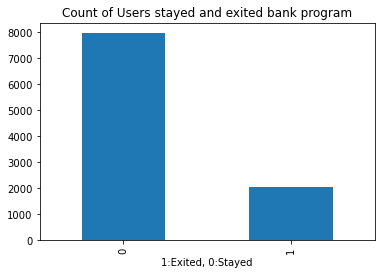

In [7]:
bank_data.Exited.value_counts().plot(kind='bar', title='Count of Users stayed and exited bank program', xlabel='1:Exited, 0:Stayed');

### Number Of Missing Values By Column<a id='Number_Of_Missing_Values_By_Column'></a>

Count the number of missing values in each column and sort them.

In [8]:
#Check for missing data
missing = pd.concat([bank_data.isnull().sum(), 100 * bank_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
RowNumber,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


Table doesn't have missing values so we don't need to look for solution how to fix them

### Categorical Features<a id='Categorical_Features'></a>

In [10]:
#Categorical data in our table
bank_data.select_dtypes('object').head()

,Surname,Geography,Gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female
3,Boni,France,Female
4,Mitchell,Spain,Female


Categorical features in this dataset is not limited only by `Surname`, `Geography` and `Gender`. Other categorical features are: `IsActiveMember` and `HasCrCard`

In [11]:
#Check unique values
categorical_features=['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender', 'IsActiveMember', 'HasCrCard']
bank_data[categorical_features].nunique()

RowNumber         10000
CustomerId        10000
Surname            2932
Geography             3
Gender                2
IsActiveMember        2
HasCrCard             2
dtype: int64

`RowNumber` and `CustomerID` has only unique values and can be dropped from dataset as well as `Surname` column as it doesn't influence on client outcome.

#### Unique Geography names<a id='Unique_Geography_names'></a>

In [13]:
bank_data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Our data contains only data for 3 countries - France, Germany and Spain

#### Distribution of clients by Geography<a id='Distribution_of_clients_by_Geography'></a>

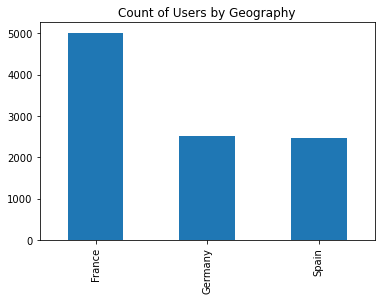

In [14]:
bank_data.Geography.value_counts().plot(kind='bar', title='Count of Users by Geography');

It looks like most clients of the bank are from France. Germay and Spain has almost same number of users.

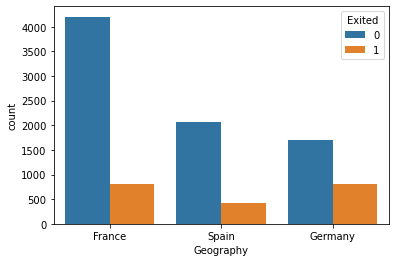

In [15]:
sns.countplot(x='Geography', hue='Exited', data=bank_data);

Despite of having less clients in Germany, bank is loosing more of them in that region

#### Distribution of clients by Gender<a id='Distribution_of_clients_by_Gender'></a>

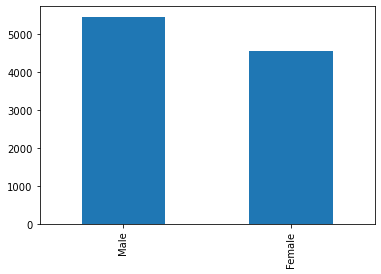

In [16]:
bank_data.Gender.value_counts().plot(kind='bar');

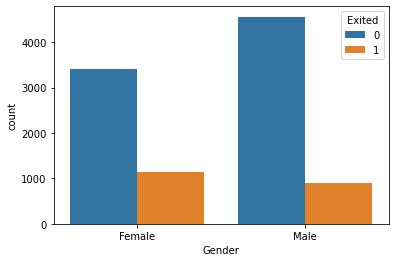

In [17]:
sns.countplot(x='Gender', hue='Exited', data=bank_data);

Women tend to leave bank more than men

#### Distribution of clients by Activity and Credit Card<a id='Distribution_of_clients_by_Activity_and_Credit_Card'></a>

Check data for both active and exited users

In [18]:
bank_data.loc[(bank_data['IsActiveMember']==1)&(bank_data['Exited']==1)].shape

(735, 14)

About 7% of users in our dataset has both flags equal 1 that means that decision to leave not only depends on activity of the user during reporting period.

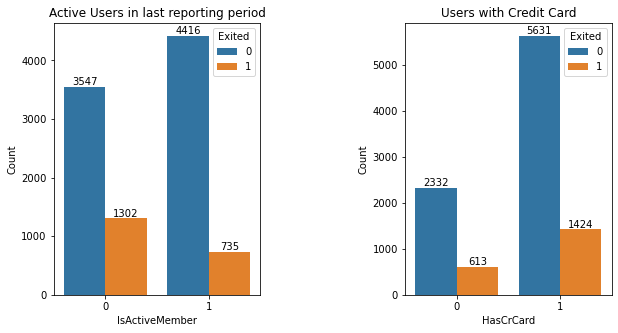

In [19]:
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='HasCrCard', hue = 'Exited',data = bank_data, ax=ax[1])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = bank_data, ax=ax[0])
ax[1].set_title('Users with Credit Card')
ax[0].set_ylabel('Count')
for container in ax[0].containers:
    ax[0].bar_label(container)

ax[0].set_title('Active Users in last reporting period')
ax[1].set_ylabel('Count')
for container in ax[1].containers:
    ax[1].bar_label(container)
plt.subplots_adjust(wspace=0.7);

Availability of the credit card doesn't influence decision to stay with bank much. Same time users which were active during last reporting period tend to stay with bank.

### Numeric Features<a id='Numeric_Features'></a>

#### Numeric data summary<a id='Numeric_data_summary'></a>

In [20]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


#### Distributions Of Feature Values<a id='Distributions_Of_Feature_Values'></a>

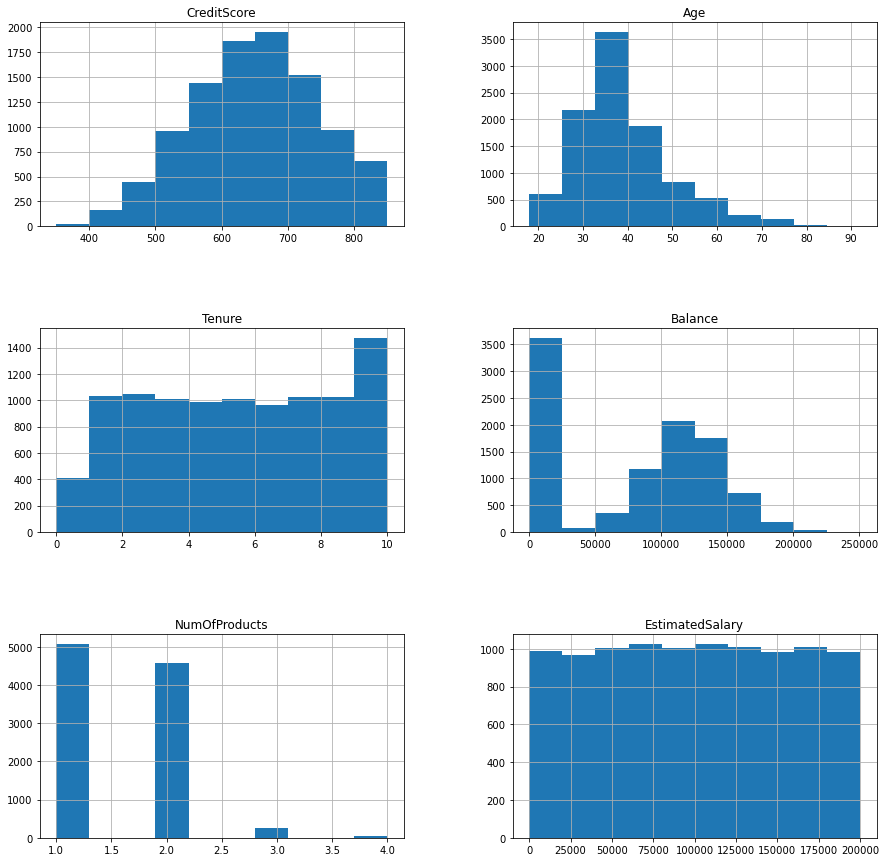

In [21]:
features=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
bank_data[features].hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);

##### Check users with 0 balance

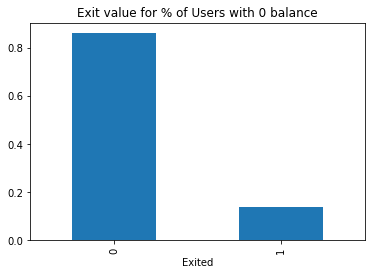

In [77]:
zero_balance=bank_data.loc[(bank_data['Balance']==0)]
zero_balance.Exited.value_counts(normalize=True).plot(kind='bar', title='Exit value for % of Users with 0 balance', xlabel='Exited');

More than 80% of users with 0 balance stayed with the bank

## Clean and Save data<a id='Save_data'></a>

### Remove unnecessary columns

In [23]:
bank_data.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Save data

In [24]:
# save the data to a new csv file
datapath = '../data'
save_file(bank_data, 'bank_data_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data/bank_data_cleaned.csv"


## Summary<a id='Summary'></a>

*Main information about DataFrame bank_data (read from csv file ‘churn.csv’):*

- Bank_data had 10000 rows and 14 columns. 
- Data types: float64(2), int64(9), object(3)
- Target feature for further prediction through classification of users is in `Exited` column with values 1 for exited user and 0 for one who stayed in the program

*Issues and observations found in data:*

- Dataframe doesn't have missing values.
- Churn rate for given data is 20.4%
- Customers from Germany are more likely to churn.
- Women are more likely to exit bank programs than men.
- Active users churn slightly less than non-active.
- 80% of users with 0 balance stayed with bank.
- 3 columns were removed from dataframe as they are not features related to modeling - `RowNumber`, `CustomerId`, `Surname`


Cleaned dataframe has 10000 rows and 11 columns.
